In [1]:
import os
import re
import sys
import glob
import uproot
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats as st
import scipy

import peakutils

from datetime import datetime

import math
from scipy          import stats
from scipy.optimize import curve_fit

from matplotlib.colors import LogNorm

In [2]:
### Import functions from peak_functions

repository_path = os.path.abspath('../..')
sys.path.append(repository_path)

import blr_functions  as blr
import peak_functions as pf
import fit_functions  as fitf

In [3]:
import matplotlib

# Set Palatino as the serif font
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif']  = 'Palatino'

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
plt.rcParams["figure.figsize"] = 7.5, 4.5
plt.rcParams["font.size"]      = 12

In [6]:
fav_col = '#418094'

In [7]:
filename = '/Users/romoluque_c/LEGEND/BACON/new_setup/datatest/run-11_25_2024-file.root'
infile   = uproot.open(filename)
RawTree  = infile['RawTree']

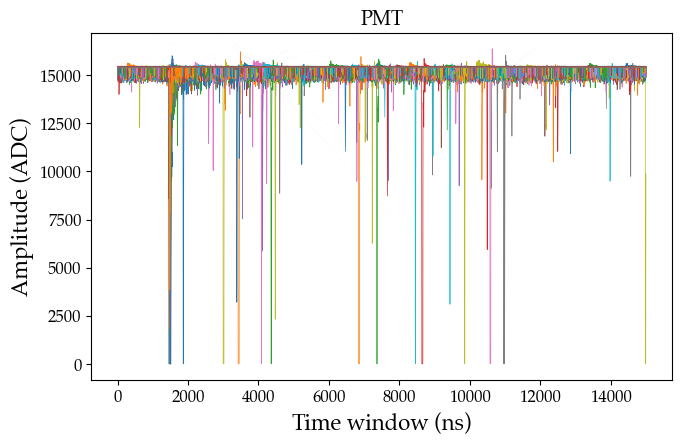

In [8]:
wfs = np.array(RawTree[f'chan12/rdigi'].array())
for wf in wfs:
    plt.plot(2*np.arange(len(wf)), wf, lw=0.5)
plt.xlabel('Time window (ns)', fontsize=16)
plt.ylabel('Amplitude (ADC)',  fontsize=16)
plt.title('PMT')
plt.show()

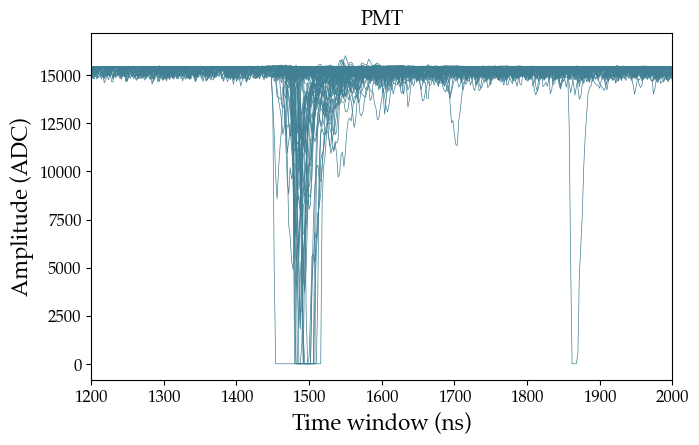

In [9]:
wfs = np.array(RawTree[f'chan12/rdigi'].array())
for wf in wfs:
    plt.plot(2*np.arange(len(wf)), wf, lw=0.5, c=fav_col)
plt.xlabel('Time window (ns)', fontsize=16)
plt.ylabel('Amplitude (ADC)',  fontsize=16)
plt.title('PMT')
plt.xlim(1200, 2000)
plt.show()

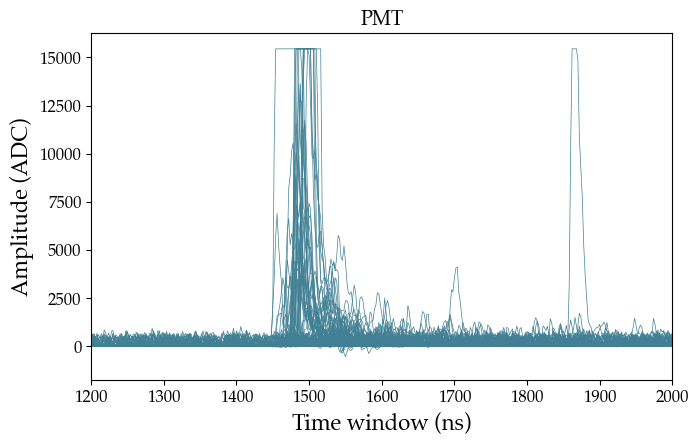

In [10]:
wfs  = np.array(RawTree[f'chan12/rdigi'].array())
cwfs = np.array([blr.pmt_deconvolver(wf, wf_range_bsl=(0, 650), baseline_mode=True, std_lim=3.6) for wf in wfs])
for cwf in cwfs:
    plt.plot(2*np.arange(len(cwf)), cwf, lw=0.5, c=fav_col)
plt.xlabel('Time window (ns)', fontsize=16)
plt.ylabel('Amplitude (ADC)',  fontsize=16)
plt.title('PMT')
plt.xlim(1200, 2000)
plt.show()

## Baseline computation

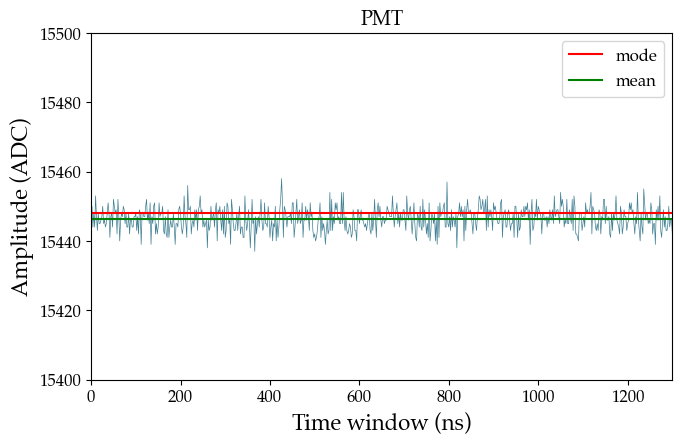

In [11]:
wfs = np.array(RawTree[f'chan12/rdigi'].array())
for wf in wfs[10:11]:
    plt.plot(2*np.arange(len(wf)), wf, lw=0.5, c=fav_col)
    mode = st.mode(wf[0:650], keepdims=False).mode.astype(np.float32)
    mean = np.mean(wf[0:650])
    plt.axhline(mode, c='r', label='mode')
    plt.axhline(mean, c='g', label='mean')
plt.xlabel('Time window (ns)', fontsize=16)
plt.ylabel('Amplitude (ADC)',  fontsize=16)
plt.title('PMT')
plt.xlim(0, 1300)
plt.ylim(15400, 15500)
plt.legend()
plt.show()

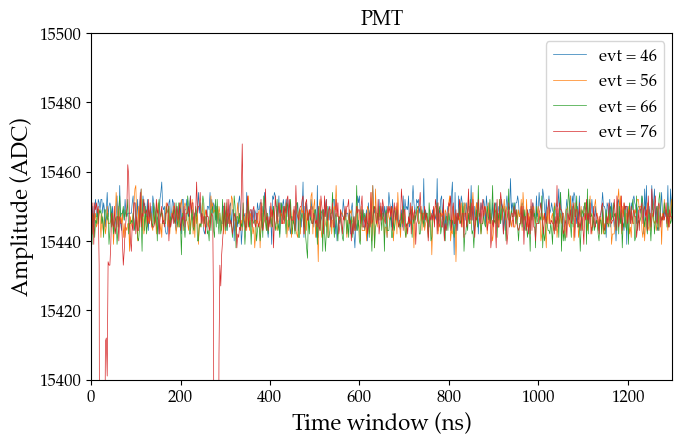

In [12]:
wfs = np.array(RawTree[f'chan12/rdigi'].array())
for i,wf in enumerate(wfs[:100]):
    if i in [46, 56, 66, 76]:
        plt.plot(2*np.arange(len(wf)), wf, lw=0.5, label=f'evt = {0 + i}')
plt.xlabel('Time window (ns)', fontsize=16)
plt.ylabel('Amplitude (ADC)',  fontsize=16)
plt.title('PMT')
plt.xlim(0, 1300)
plt.ylim(15400, 15500)
plt.legend()
plt.show()

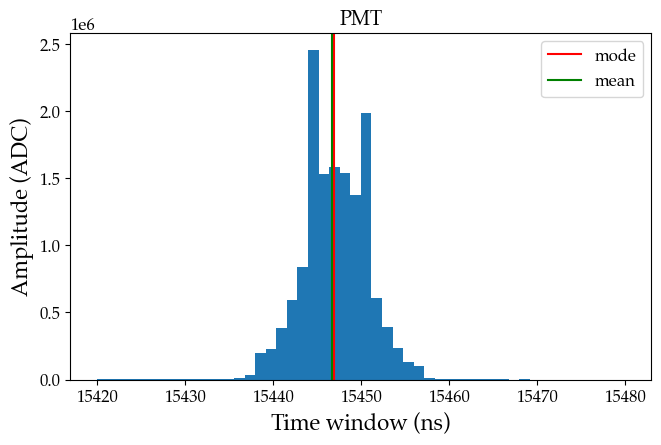

In [13]:
wfs = np.array(RawTree[f'chan12/rdigi'].array())
iwf_vals = np.array([])
for wf in wfs:
    iwf_vals = np.concatenate((iwf_vals, wf[0:650]))
plt.hist(iwf_vals, bins=50, range=(15420, 15480))
mode = st.mode(iwf_vals, keepdims=False).mode.astype(np.float32)
mean = np.mean(iwf_vals)
plt.axvline(mode, c='r', label='mode')
plt.axvline(mean, c='g', label='mean')
plt.xlabel('Time window (ns)', fontsize=16)
plt.ylabel('Amplitude (ADC)',  fontsize=16)
plt.title('PMT')
plt.legend()
plt.show()

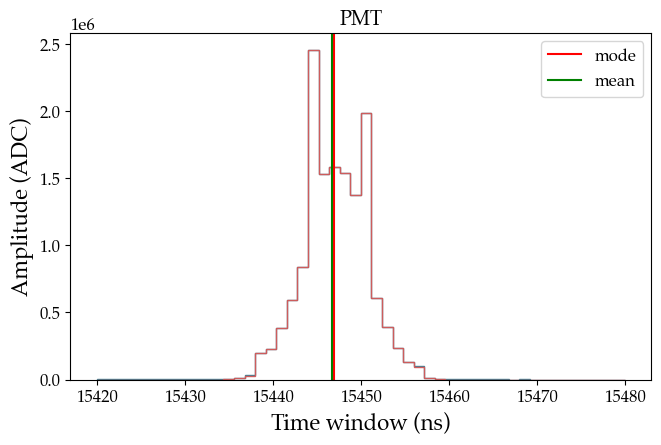

In [14]:
wfs = np.array(RawTree[f'chan12/rdigi'].array())
iwf_vals0 = np.array([])
iwf_vals1 = np.array([])
for wf in wfs:
    wf_sel_region = wf[0:650]
    low_bnd = st.mode(wf, keepdims=False).mode.astype(np.float32) - 3*3.5
    upp_bnd = st.mode(wf, keepdims=False).mode.astype(np.float32) + 3*3.5
    filt_wf = wf_sel_region[(wf_sel_region >= low_bnd) & (wf_sel_region <= upp_bnd)]
    iwf_vals0 = np.concatenate((iwf_vals0, wf[0:650]))
    iwf_vals1 = np.concatenate((iwf_vals1, filt_wf))
plt.hist(iwf_vals0, bins=50, range=(15420, 15480), color=fav_col,     histtype='step')
plt.hist(iwf_vals1, bins=50, range=(15420, 15480), color='indianred', histtype='step')
mode = st.mode(iwf_vals, keepdims=False).mode.astype(np.float32)
mean = np.mean(iwf_vals)
plt.axvline(mode, c='r', label='mode')
plt.axvline(mean, c='g', label='mean')
plt.xlabel('Time window (ns)', fontsize=16)
plt.ylabel('Amplitude (ADC)',  fontsize=16)
plt.title('PMT')
plt.legend()
plt.show()

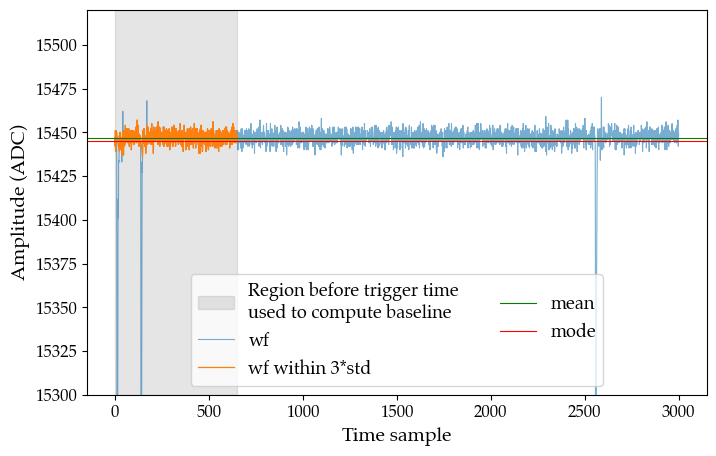

In [15]:
wf_pmt = np.array(RawTree[f'chan12/rdigi'].array())[76]
wf_ch9 = np.array(RawTree[f'chan9/rdigi'] .array())[76]

std_chs = 4
std_lim = std_chs*3

low_bnd = np.mean(wf_pmt) - std_lim #ADC
upp_bnd = np.mean(wf_pmt) + std_lim #ADC
filt_wf_pmt = wf_pmt[:650]  [(wf_pmt[:650] >= low_bnd) & (wf_pmt[:650] <= upp_bnd)]
xvals       = np.arange(650)[(wf_pmt[:650] >= low_bnd) & (wf_pmt[:650] <= upp_bnd)]


plt.figure(figsize=(8, 5))
#plt.plot(wf_ch9     [:3000]+(np.mean(filt_wf_pmt) - np.mean(wf_ch9[3000:])), label="trigger SiPM wf", lw=0.6, c='k')
plt.axvspan(0, 650, color='grey', alpha=0.2, label='Region before trigger time \nused to compute baseline')
plt.plot(wf_pmt     [:3000], label="wf", alpha=0.6, lw=0.8)
plt.plot(xvals, filt_wf_pmt[:650],  label=f"wf within 3*std", lw=0.9)
plt.axhline(np.mean(filt_wf_pmt[:650]), label='mean', lw=0.8, c='g')
plt.axhline(st.mode(filt_wf_pmt[:650], keepdims=False).mode.astype(np.float32), c='r', label='mode', lw=0.8)
plt.xlabel('Time sample',     fontsize=14)
plt.ylabel('Amplitude (ADC)', fontsize=14)
plt.ylim(15300, 15520)
plt.legend(loc='lower center', ncol=2, fontsize=13)
plt.show()

## Look at the trigger time

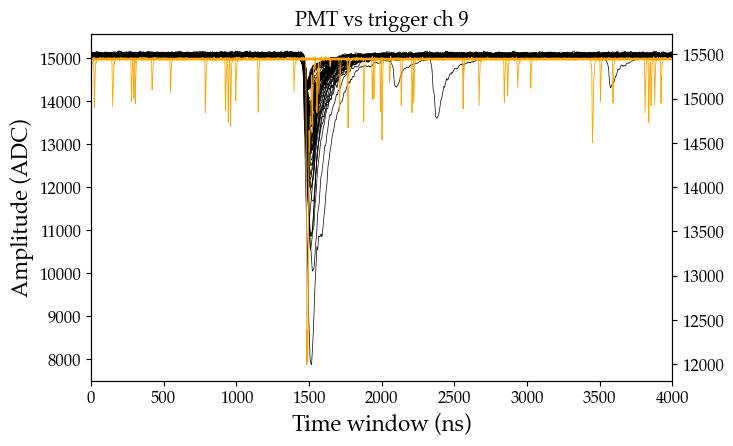

In [16]:
wfs       = np.array(RawTree[f'chan12/rdigi'].array())
wfs_trigg = np.array(RawTree[f'chan9/rdigi'].array())[:100]
fig, ax1  = plt.subplots()
for wf in wfs_trigg[:100]:
    ax1.plot(2*np.arange(len(wf)), wf, lw=0.5, color='k')
ax2 = ax1.twinx()
for wf in wfs[:100]:
    ax2.plot(2*np.arange(len(wf)), wf, lw=0.6, color='orange')
ax1.set_xlabel('Time window (ns)', fontsize=16)
ax1.set_ylabel('Amplitude (ADC)',  fontsize=16)
ax1.set_title('PMT vs trigger ch 9')
ax1.set_xlim(0, 4000)
ax2.set_xlim(0, 4000)
plt.show()

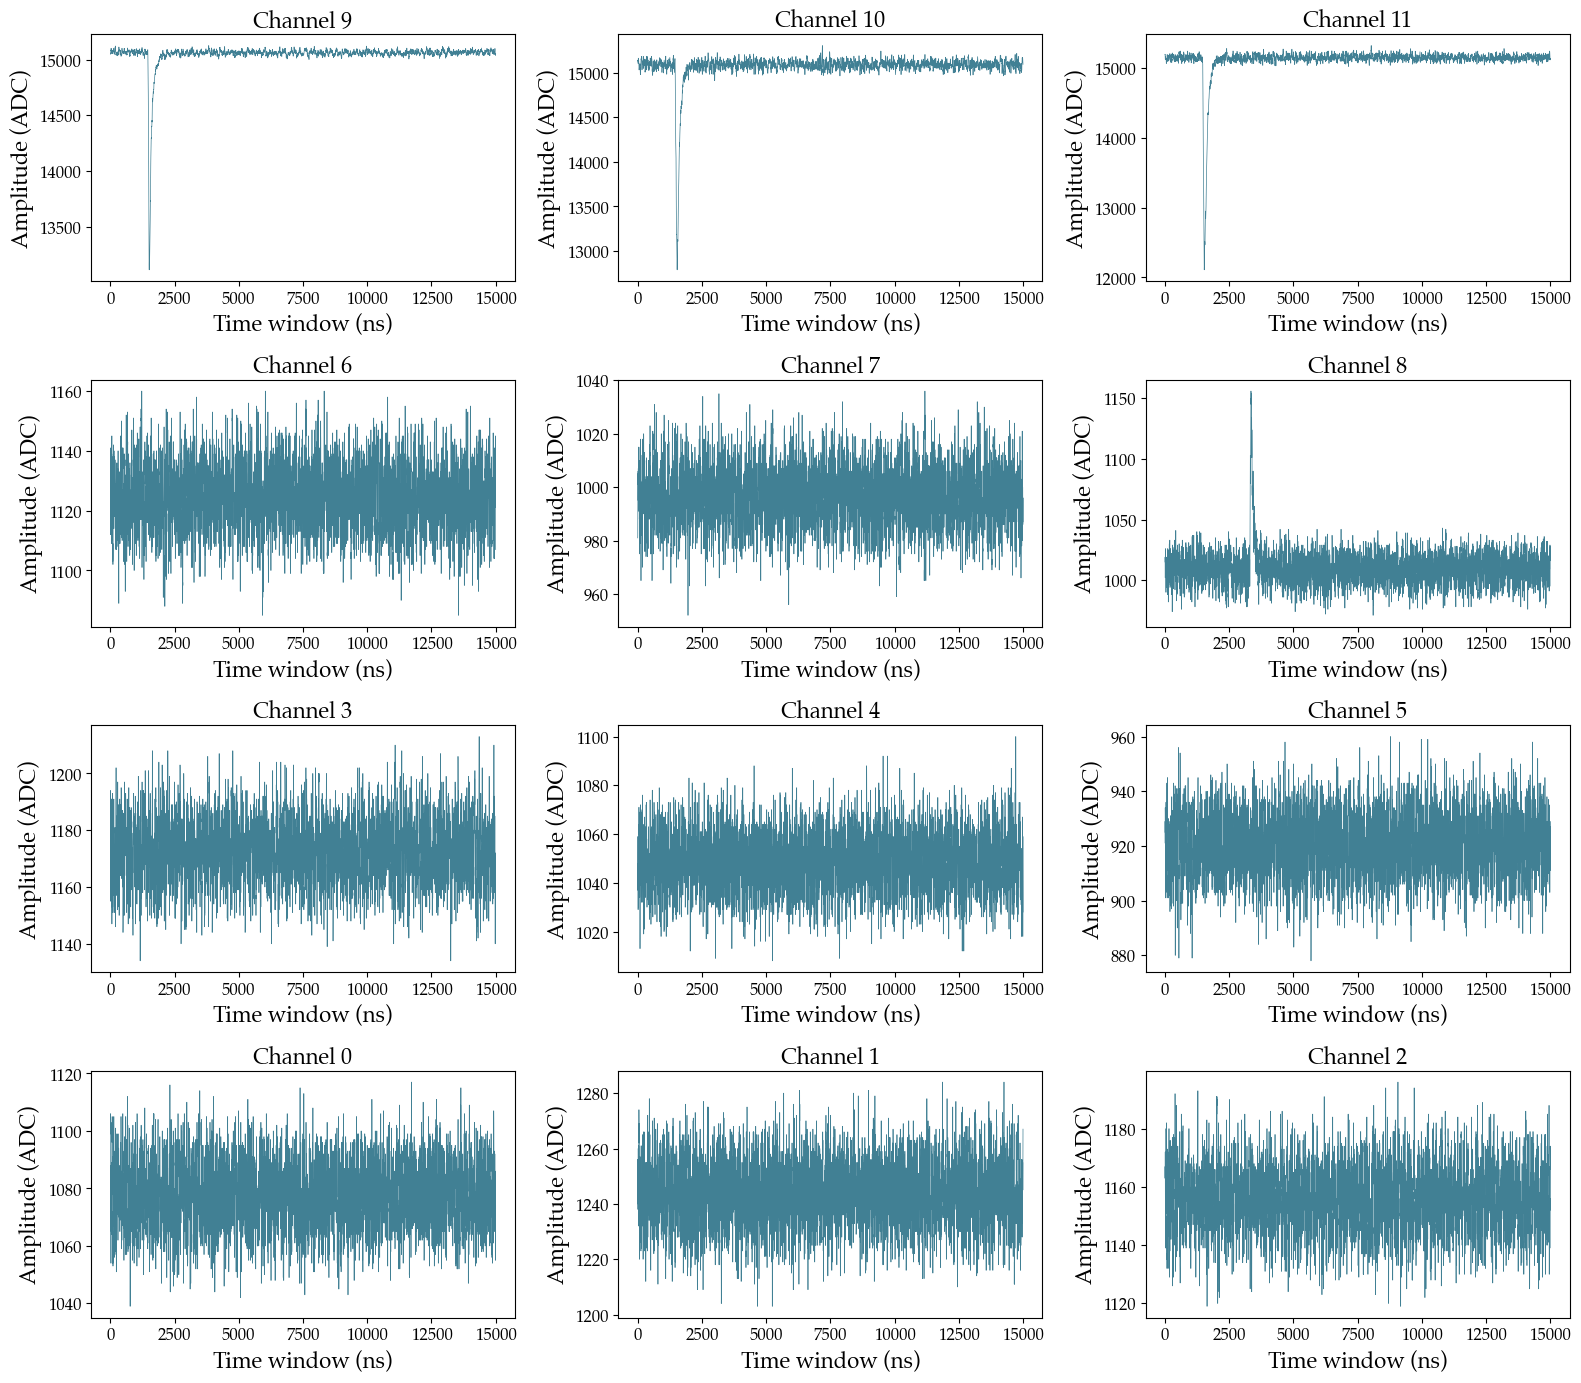

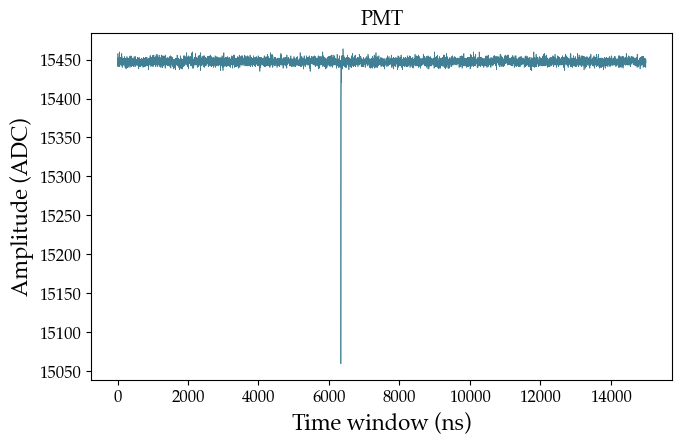

In [17]:
choose_evt = 419
fig, axs   = plt.subplots(4, 3, figsize=(16, 14))
for row, ich in enumerate(reversed(np.arange(0, 12, 3))):
    for col in range(3):
        ch = ich + col
        wf0  = np.array(RawTree[f'chan{ch}/rdigi'].array())[choose_evt]
        swf0 = pf.subtract_baseline(wf0, mode=True, wf_range_bsl=(0, 500))
        wf1  = np.array(RawTree[f'chan12/rdigi'].array())[choose_evt]
        swf1 = pf.subtract_baseline(wf1, mode=True, wf_range_bsl=(0, 500))
        axs[row][col].plot(2*np.arange(len(wf0)), wf0, lw=0.5, color=fav_col)
        axs[row][col].set_xlabel('Time window (ns)', fontsize=16)
        axs[row][col].set_ylabel('Amplitude (ADC)',  fontsize=16)
        axs[row][col].set_title(f"Channel {ch}",     fontsize=16)
plt.tight_layout()
plt.show()

wf0  = np.array(RawTree[f'chan12/rdigi'].array())[choose_evt]
plt.plot(2*np.arange(len(wf0)), wf0, lw=0.5, color=fav_col)
plt.xlabel('Time window (ns)', fontsize=16)
plt.ylabel('Amplitude (ADC)',  fontsize=16)
plt.title('PMT')
plt.show()

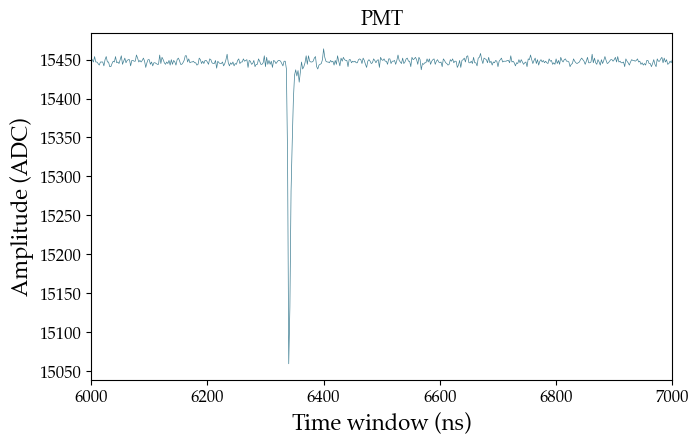

In [18]:
wf0  = np.array(RawTree[f'chan12/rdigi'].array())[choose_evt]
plt.plot(2*np.arange(len(wf0)), wf0, lw=0.5, color=fav_col)
plt.xlabel('Time window (ns)', fontsize=16)
plt.ylabel('Amplitude (ADC)',  fontsize=16)
plt.title('PMT')
plt.xlim(6000, 7000)
plt.show()

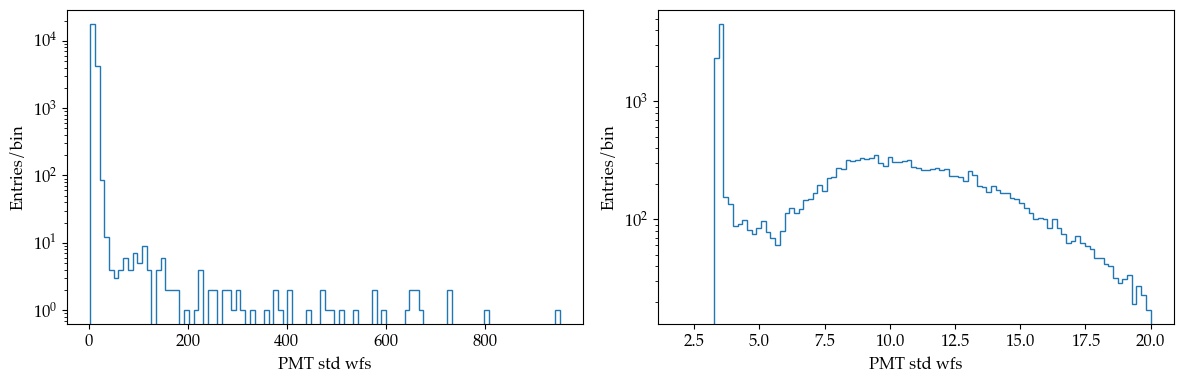

In [19]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))
pmt_stds = np.std(np.array(RawTree[f'chan12/rdigi'].array()), axis=1)
ax0.hist(pmt_stds, bins=100,                log=True, histtype='step')
ax1.hist(pmt_stds, bins=100, range=(2, 20), log=True, histtype='step')
for ax in [ax0, ax1]:
    ax.set_xlabel('PMT std wfs')
    ax.set_ylabel('Entries/bin')
plt.tight_layout()
plt.show()

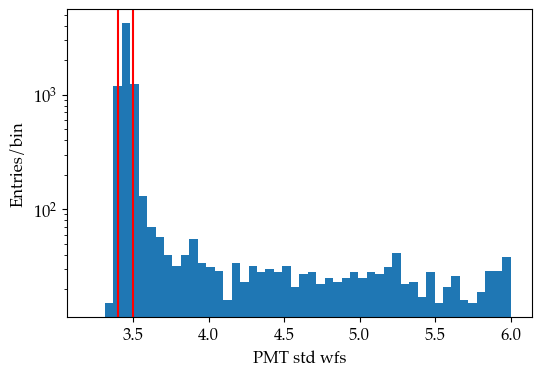

In [20]:
plt.figure(figsize=(6, 4))
plt.hist(pmt_stds, bins=50, range=(3.2, 6), log=True)
plt.axvline(3.4, c='r')
plt.axvline(3.5, c='r')

plt.xlabel('PMT std wfs')
plt.ylabel('Entries/bin')
plt.show()

### Look at events with different std

328


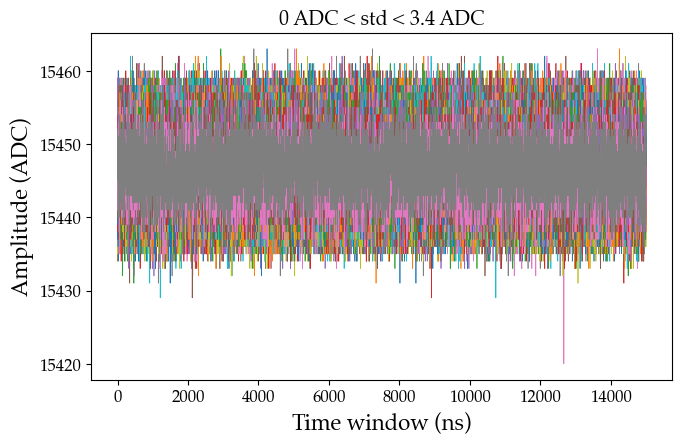

5883


In [ ]:
wfs      = np.array(RawTree[f'chan12/rdigi'].array())
pmt_stds = np.std(wfs, axis=1)
std_lims = [(0, 3.4), (3.4, 3.5), (3.5, 3.6), (3.6, 4), (4, 7), (7, 10), (10, 20), (20, 1000000)]

for l_thr, u_thr in std_lims:
    std_thr = np.where((pmt_stds>l_thr)&(pmt_stds<u_thr))[0]
    sel_wfs = wfs[std_thr]
    print(len(sel_wfs))
    for wf in sel_wfs:
        plt.plot(2*np.arange(len(wf)), wf, lw=0.5)
    plt.xlabel('Time window (ns)', fontsize=16)
    plt.ylabel('Amplitude (ADC)',  fontsize=16)
    plt.title(f'{l_thr} ADC < std < {u_thr} ADC')
    plt.show()

In [ ]:
wfs      = np.array(RawTree[f'chan12/rdigi'].array())
pmt_stds = np.std(wfs, axis=1)
std_lims = [(20, 1000000)]

fig, ax = plt.subplots()

for l_thr, u_thr in std_lims:
    std_thr = np.where((pmt_stds>l_thr)&(pmt_stds<u_thr))[0]
    sel_wfs = wfs[std_thr]
    print(len(sel_wfs))
    for wf in sel_wfs[14:15]:
        ax.plot(2*np.arange(len(wf)), wf, lw=0.5, c=fav_col)
square = patches.Rectangle((3000, 14200), 6500, 1800, lw=1, edgecolor='grey', facecolor='grey', alpha=0.2)
ax.add_patch(square)

ax.set_xlabel('Time window (ns)', fontsize=16)
ax.set_ylabel('Amplitude (ADC)',  fontsize=16)
plt.show()

In [ ]:
wfs      = np.array(RawTree[f'chan12/rdigi'].array())
pmt_stds = np.std(wfs, axis=1)
std_lims = [(20, 1000000)]

for l_thr, u_thr in std_lims:
    std_thr = np.where((pmt_stds>l_thr)&(pmt_stds<u_thr))[0]
    sel_wfs = wfs[std_thr]
    for wf in sel_wfs[55:100]:
        plt.plot(2*np.arange(len(wf)), wf, lw=0.5)
plt.xlabel('Time window (ns)', fontsize=16)
plt.ylabel('Amplitude (ADC)',  fontsize=16)
plt.show()

In [ ]:
wfs = np.array(RawTree[f'chan12/rdigi'].array())
for i, wf in enumerate(wfs):
    if i in [95, 831, 3021]:
        plt.plot(2*np.arange(len(wf)), wf, lw=0.5, c=fav_col)
        plt.xlabel('Time window (ns)', fontsize=16)
        plt.ylabel('Amplitude (ADC)',  fontsize=16)
        if i==831:
            plt.xlim(3000, 9500)
            plt.ylim(14200, 16000)
        plt.show()

## Split in groups and compute the maximum/minimum of the wf to get the SPE spectrum

In [ ]:
wfs        = np.array(RawTree[f'chan12/rdigi'].array())
wfs_ab_bsl = wfs[np.where(pmt_stds>3.4)[0]]
pmt_maxs0  = np.max(wfs, axis=1)
pmt_maxs1  = np.max(wfs_ab_bsl, axis=1)

plt.hist(pmt_maxs0, bins=150, range=(15450, 15600), log=True, histtype='step', lw=0.8);
plt.hist(pmt_maxs1, bins=150, range=(15450, 15600), log=True, histtype='step', lw=0.8);

In [ ]:
wfs         = np.array(RawTree[f'chan12/rdigi'].array())
cwfs        = np.array([blr.pmt_deconvolver(wf, wf_range_bsl=(0, 650), baseline_mode=True, std_lim=3.6) for wf in wfs])
cwfs_ab_bsl = cwfs[np.where(pmt_stds>3.4)[0]]

pmt_maxs0  = np.max(cwfs,        axis=1)
pmt_maxs1  = np.max(cwfs_ab_bsl, axis=1)

In [ ]:
plt.hist(pmt_maxs0, bins=100, range=(0, 1000), log=True, histtype='step', lw=0.8);
plt.hist(pmt_maxs1, bins=100, range=(0, 1000), log=True, histtype='step', lw=0.8);

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))
ax0.hist(pmt_maxs0, bins=100, range=(  0,  100), log=True, histtype='step')
ax1.hist(pmt_maxs0, bins=100, range=(200, 1000), log=True, histtype='step')
for ax in [ax0, ax1]:
    ax.set_xlabel('PMT max wfs')
    ax.set_ylabel('Entries/bin')
plt.tight_layout()
plt.show()

In [ ]:
wfs      = np.array(RawTree[f'chan12/rdigi'].array())
pmt_stds = np.std(wfs, axis=1)
std_lims = [(0, 3.4), (3.4, 3.5), (3.5, 3.6), (3.6, 4), (4, 7), (7, 10), (10, 20), (20, 1000000)]

for l_thr, u_thr in std_lims:
    std_thr = np.where((pmt_stds>l_thr)&(pmt_stds<u_thr))[0]
    sel_wfs = wfs[std_thr]
    cwfs    = np.array([blr.pmt_deconvolver(wf, wf_range_bsl=(0, 650), baseline_mode=True, std_lim=3.6) for wf in sel_wfs])
    print(len(cwfs))
    plt.hist(np.max(cwfs, axis=1), bins=100, range=(10, 1000), log=True)
    plt.xlabel('Max wf (ADC)', fontsize=16)
    plt.ylabel('Entries/bin',  fontsize=16)
    plt.title(f'{l_thr} ADC < std < {u_thr} ADC')
    plt.show()

## For the SPE spectrum we could take the trigger region

In [ ]:
wfs         = np.array(RawTree[f'chan12/rdigi'].array())
cwfs        = np.array([blr.pmt_deconvolver(wf, wf_range_bsl=(0, 650), baseline_mode=True, std_lim=3.6) for wf in wfs])
cwfs_ab_bsl = cwfs[np.where(pmt_stds>3.4)[0]]

pmt_maxs0_tr = np.max(cwfs       [:, 650:850], axis=1) #trigger region
pmt_maxs1_tr = np.max(cwfs_ab_bsl[:, 650:850], axis=1) #trigger region

In [ ]:
plt.figure(figsize=(10, 4))
plt.hist(pmt_maxs0_tr, bins=150, range=(0, 900), log=True, histtype='step')
plt.xlabel('PMT max wfs')
plt.ylabel('Entries/bin')
plt.show()

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))
ax0.hist(pmt_maxs0_tr, bins=100, range=(  0,  100), log=True, histtype='step')
ax1.hist(pmt_maxs0_tr, bins=100, range=(200, 1000), log=True, histtype='step')
for ax in [ax0, ax1]:
    ax.set_xlabel('PMT max wfs')
    ax.set_ylabel('Entries/bin')
plt.tight_layout()
plt.show()

In [ ]:
std_thr_dict = {0: 13,
                1: 13,
                2: 13,
                3: 13,
                4: 14,
                5: 13,
                6: 12,
                7: 13,
                8: 13,
                9: 30,
                10: 40,
                11: 40,
                12:  4}

In [ ]:
pmt_ch = 12
min_PMT_val     = np.min   (np.array(RawTree[f'chan{pmt_ch}/rdigi'].array()), axis=1) - np.mean(np.array(RawTree[f'chan12/rdigi'].array()), axis=1)
idx_min_PMT_val = np.argmin(np.array(RawTree[f'chan{pmt_ch}/rdigi'].array()), axis=1)

In [ ]:
wfs       = np.array(RawTree[f'chan{pmt_ch}/rdigi'].array())
cwfs      = np.array([blr.pmt_deconvolver(wf, wf_range_bsl=(0, 650), baseline_mode=True, std_lim=3*std_thr_dict[pmt_ch]) for wf in wfs])
pmt_maxs0 = np.max(cwfs[:, 650:850], axis=1)

In [ ]:
for ch_row in [(8, 7, 6), (5, 4, 3), (2, 1, 0)]:
    plt.hist(pmt_maxs0, bins=100, range=(0, 1000), log=True, alpha=0.7, label='PMT')
    for ch in ch_row:
        wfs        = np.array(RawTree[f'chan{ch}/rdigi'].array())
        swfs       = pf.subtract_baseline_std_lim(wfs, mode=False, wf_range_bsl=(0, 650), std_lim=3*std_thr_dict[ch])
        max_ch_val = np.max(swfs[:, 650:850], axis=1)
        plt.hist(max_ch_val,  bins=100, range=(0, 1000), log=True, alpha=0.7, label=f'Ch {ch}')
    plt.xlabel('Max ampl (ADC)')
    plt.ylabel('Entries/bin')
    plt.legend()
    plt.show()

In [ ]:
plt.hist(pmt_maxs0, bins=100, range=(0, 5000), log=True, alpha=0.7, label='PMT', histtype='step')
for ch in [9, 10, 11]:
    wfs        = np.array(RawTree[f'chan{ch}/rdigi'].array())
    cwfs       = np.array([blr.pmt_deconvolver(wf, wf_range_bsl=(0, 650), baseline_mode=True, std_lim=3*std_thr_dict[ch]) for wf in wfs])
    max_ch_val = np.max(cwfs[:, 650:850], axis=1)
    plt.hist(max_ch_val,  bins=100, range=(0, 5000), log=True, alpha=0.7, label=f'Ch {ch}', histtype='step')
plt.xlabel('Max ampl (ADC)')
plt.ylabel('Entries/bin')
plt.legend()
plt.show()

In [ ]:
for ch in range(9):
    wfs        = np.array(RawTree[f'chan{ch}/rdigi'].array())
    swfs       = pf.subtract_baseline_std_lim(wfs, mode=False, wf_range_bsl=(0, 650), std_lim=3*std_thr_dict[ch])
    max_ch_val = np.max(swfs, axis=1)
    plt.hist2d(pmt_maxs0, max_ch_val, bins=(150, 100), range=((0, 16000), (0, 16000)), cmin=1, norm=LogNorm())
    plt.xlabel('PMT max ampl (ADC)')
    plt.ylabel(f'Channel {ch} max ampl (ADC)')
    plt.title(f'Channel {ch} vs PMT')
    plt.colorbar(pad=0.02)
    plt.show()

In [ ]:
for ch in range(9):
    wfs        = np.array(RawTree[f'chan{ch}/rdigi'].array())
    swfs       = pf.subtract_baseline_std_lim(wfs, mode=False, wf_range_bsl=(0, 650), std_lim=3*std_thr_dict[ch])
    max_ch_val = np.max(swfs, axis=1)
    plt.hist2d(pmt_maxs0, max_ch_val, bins=(150, 100), range=((0, 1000), (0, 500)), cmin=1, norm=LogNorm())
    plt.xlabel('PMT max ampl (ADC)')
    plt.ylabel(f'Channel {ch} max ampl (ADC)')
    plt.title(f'Channel {ch} vs PMT')
    plt.colorbar(pad=0.02)
    plt.show()

In [ ]:
for ch in range(9):
    wfs        = np.array(RawTree[f'chan{ch}/rdigi'].array())
    swfs       = pf.subtract_baseline_std_lim(wfs, mode=False, wf_range_bsl=(0, 650), std_lim=3*std_thr_dict[ch])
    max_ch_val = np.max(swfs, axis=1)
    plt.hist2d(pmt_maxs0, max_ch_val, bins=(100, 100), range=((0, 100), (0, 500)), cmin=1, norm=LogNorm())
    plt.xlabel('PMT max ampl (ADC)')
    plt.ylabel(f'Channel {ch} max ampl (ADC)')
    plt.title(f'Channel {ch} vs PMT')
    plt.colorbar(pad=0.02)
    plt.show()

In [ ]:
for ch in [9, 10, 11][:1]:
    wfs        = np.array(RawTree[f'chan{ch}/rdigi'].array())
    swfs       = np.array([blr.pmt_deconvolver(wf, wf_range_bsl=(0, 650), std_lim=3*std_thr_dict[ch]) for wf in wfs])
    max_ch_val = np.max(swfs, axis=1)
    plt.hist2d(pmt_maxs0, max_ch_val, bins=(150, 100), range=((0, 1000), (0, 8000)), cmin=1, norm=LogNorm())
    plt.xlabel('PMT max ampl (ADC)')
    plt.ylabel(f'Channel {ch} max ampl (ADC)')
    plt.title(f'Channel {ch} vs PMT')
    plt.colorbar(pad=0.02)
    plt.show()

In [ ]:
for ch in [9, 10, 11][:1]:
    wfs        = np.array(RawTree[f'chan{ch}/rdigi'].array())
    swfs       = np.array([blr.pmt_deconvolver(wf, wf_range_bsl=(0, 650), std_lim=3*std_thr_dict[ch]) for wf in wfs])
    max_ch_val = np.max(swfs, axis=1)
    plt.hist2d(pmt_maxs0, max_ch_val, bins=(100, 100), range=((0, 100), (0, 8000)), cmin=1, norm=LogNorm())
    plt.xlabel('PMT max ampl (ADC)')
    plt.ylabel(f'Channel {ch} max ampl (ADC)')
    plt.title(f'Channel {ch} vs PMT')
    plt.colorbar(pad=0.02)
    plt.show()

In [ ]:
wfs         = np.array(RawTree[f'chan12/rdigi'].array())
cwfs        = np.array([blr.pmt_deconvolver(wf, wf_range_bsl=(0, 650), baseline_mode=True, std_lim=3.6) for wf in wfs])
idx_max_pmt = np.argmax(cwfs, axis=1)

In [ ]:
for ch in range(9):
    wfs        = np.array(RawTree[f'chan{ch}/rdigi'].array())
    swfs       = pf.subtract_baseline_std_lim(wfs, mode=False, wf_range_bsl=(0, 650), std_lim=3*std_thr_dict[ch])
    idx_max_ch = np.argmax(swfs, axis=1)
    
    plt.hist2d(idx_max_pmt, idx_max_ch, bins=(10, 10), range=((740, 760), (700, 800)), cmin=1)
    plt.xlabel('PMT timestamp (ns)')
    plt.ylabel(f'Channel {ch} timestamp (ns)')
    plt.title(f'Channel {ch} vs PMT')
    plt.colorbar(pad=0.02)
    plt.show()

## Analyze data:

In [ ]:
import re

evts_path = '/Users/romoluque_c/LEGEND/BACON/new_setup/data_npz_run3/'

all_chs = range(13)

def extract_date_obj_and_number(filename):
    match       = re.search(r"(\d{2}_\d{2}_\d{4})-file_(\d+)", filename)
    date_str    = match.group(1)
    file_number = int(match.group(2))
    date_obj    = datetime.strptime(date_str, "%m_%d_%Y")
    return date_obj, file_number

def extract_date_and_number(filename):
    match = re.search(r"(\d{2}_\d{2}_\d{4})-file_(\d+)", filename)
    return match.group(1), int(match.group(2))

files        = glob.glob(evts_path + 'BACoN_pmt_analysis_run-*.npz')
sorted_files = sorted(files, key=extract_date_obj_and_number)

In [ ]:
max_vals_dict = {}
idx_vals_dict = {}

all_chs = range(13)

for filename in sorted_files:
    d          = np.load(filename, allow_pickle=True)
    date, fnum = extract_date_and_number(filename)
    
    if date not in max_vals_dict:
        print(date)
        max_vals_dict[date] = {ch: d['max_vals_dict'].item()[ch] for ch in all_chs}
        idx_vals_dict[date] = {ch: d['idx_vals_dict'].item()[ch] for ch in all_chs}
        continue

    for ch in all_chs:
        try:
            max_vals_dict[date][ch] = np.concatenate((max_vals_dict[date][ch], d['max_vals_dict'].item()[ch]))
            idx_vals_dict[date][ch] = np.concatenate((idx_vals_dict[date][ch], d['idx_vals_dict'].item()[ch]))
            
        except Exception as e:
            print(date, fnum, filename, ch, str(e))
            continue

In [ ]:
max_vals_dict;

In [ ]:
dates = max_vals_dict.keys()
for ch in range(9):
    pmt_vals  = np.concatenate([max_vals_dict[date][12] for date in dates])
    sipm_vals = np.concatenate([max_vals_dict[date][ch] for date in dates])
    plt.hist2d(pmt_vals, sipm_vals, bins=(150, 100), range=((0, 16000), (0, 600)), cmin=1, norm=LogNorm())
    plt.xlabel('PMT max ampl (ADC)')
    plt.ylabel(f'Channel {ch} max ampl (ADC)')
    plt.title(f'Channel {ch} vs PMT')
    plt.colorbar(pad=0.02)
    plt.show()

In [ ]:
dates = max_vals_dict.keys()
for ch in range(9):
    pmt_vals  = np.concatenate([max_vals_dict[date][12] for date in dates])
    sipm_vals = np.concatenate([max_vals_dict[date][ch] for date in dates])
    plt.hist2d(pmt_vals, sipm_vals, bins=(150, 100), range=((0, 1000), (0, 600)), cmin=1, norm=LogNorm())
    plt.xlabel('PMT max ampl (ADC)')
    plt.ylabel(f'Channel {ch} max ampl (ADC)')
    plt.title(f'Channel {ch} vs PMT')
    plt.colorbar(pad=0.02)
    plt.show()

In [ ]:
dates = max_vals_dict.keys()
for ch in range(9):
    pmt_vals  = np.concatenate([max_vals_dict[date][12] for date in dates])
    sipm_vals = np.concatenate([max_vals_dict[date][ch] for date in dates])
    plt.hist2d(pmt_vals, sipm_vals, bins=(150, 100), range=((0, 100), (0, 600)), cmin=1, norm=LogNorm())
    plt.xlabel('PMT max ampl (ADC)')
    plt.ylabel(f'Channel {ch} max ampl (ADC)')
    plt.title(f'Channel {ch} vs PMT')
    plt.colorbar(pad=0.02)
    plt.show()

In [ ]:
for ch in range(12):
    pmt_ids  = np.concatenate([idx_vals_dict[date][12] for date in dates])
    sipm_ids = np.concatenate([idx_vals_dict[date][ch] for date in dates])
    
    plt.hist2d(pmt_ids, sipm_ids, bins=(50, 50), range=((700, 800), (700, 800)), cmin=1)
    plt.xlabel('PMT timestamp (ns)')
    plt.ylabel(f'Channel {ch} timestamp (ns)')
    plt.title(f'Channel {ch} vs PMT')
    plt.colorbar(pad=0.02)
    plt.show()

### Same with the trigger channels

In [ ]:
for ch in [9, 10, 11]:
    pmt_vals  = np.concatenate([max_vals_dict[date][12] for date in dates])
    sipm_vals = np.concatenate([max_vals_dict[date][ch] for date in dates])
    plt.hist2d(pmt_vals, sipm_vals, bins=(100, 100), range=((0, 2000), (0, 8000)), cmin=1, norm=LogNorm())
    plt.xlabel('PMT max ampl (ADC)')
    plt.ylabel(f'Channel {ch} max ampl (ADC)')
    plt.title(f'Channel {ch} vs PMT')
    plt.colorbar(pad=0.02)
    plt.show()

## Compute the integral of the PMT pulses

### For that we search for the peaks and then take 1 μs after the peak

People from ProtoDUNE: the peak time is the time bin when the signal reaches the maximum amplitude and the S1 charge is defined as the integral over 3 μs after the peak time (but I think that's too much in our case, it would be 3000 ns!!!!)

In [ ]:
choose_evt = 419
wf  = np.array(RawTree[f'chan12/rdigi'].array())[choose_evt]
cwf = blr.pmt_deconvolver(wf, wf_range_bsl=(0, 650), baseline_mode=True, std_lim=3*std_thr_dict[pmt_ch])
plt.plot(2*np.arange(len(cwf)), cwf, color=fav_col, label='PMT convoluted wf')
plt.axvspan(6330, 6400, alpha=0.2, color='grey', label='range of 70 ns')
plt.xlabel('Time window (ns)', fontsize=16)
plt.ylabel('Amplitude (ADC)',  fontsize=16)
plt.title('PMT')
plt.xlim(6100, 6800)
plt.legend()
plt.show()

### What's the typical length of the PMT pulses?

In [ ]:
pmt_ch   = 12
wfs      = np.array(RawTree[f'chan{pmt_ch}/rdigi'].array())
cwfs     = np.array([blr.pmt_deconvolver(wf, wf_range_bsl=(0, 650), baseline_mode=True, std_lim=3*std_thr_dict[pmt_ch]) for wf in wfs])
max_swfs = np.max(cwfs, axis=1)

In [ ]:
for wf, mwf in zip(cwfs[:100], max_swfs[:100]):
    if mwf > 400:
        continue
    plt.plot(2*np.arange(len(wf[np.argmax(wf)-20:np.argmax(wf)+60])), wf[np.argmax(wf)-20:np.argmax(wf)+60], lw=0.5, color=fav_col, alpha=0.9)
plt.title(f'Channel {pmt_ch}')
plt.xlabel('Time window (ns)', fontsize=14)
plt.ylabel('Amplitude (ADC)',  fontsize=14)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

#### PMT baseline

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))
ax0.hist(np.concatenate(cwfs[:100]), bins=100, range=(-50, 50))
ax1.hist(np.concatenate(cwfs[:100]), bins=100, range=(-50, 50), log=True)
for ax, title in zip([ax0, ax1], ['lin', 'log']):
    ax.axvline(20, color='r')
    ax.set_xlabel('PMT baseline (ADC)')
    ax.set_ylabel('Entries/bin')
    ax.set_title(title)
plt.tight_layout()
plt.show()

In [ ]:
for i, (wf, mwf) in enumerate(zip(cwfs[:100], max_swfs[:100])):
    print(i, np.where(wf>20)[0])

In [ ]:
sel_evt = 14
zwf     = pf.suppress_wf(cwfs[sel_evt], 20)
plt.plot(2*np.arange(len(cwfs[sel_evt])), cwfs[sel_evt], lw=0.5, color=fav_col, alpha=0.9)
plt.plot(2*np.arange(len(zwf)), zwf, lw=0.5, color='k', alpha=0.9)
plt.title(f'Channel {pmt_ch}')
plt.xlabel('Time window (ns)', fontsize=14)
plt.ylabel('Amplitude (ADC)',  fontsize=14)
plt.xlim(9200, 9500)
plt.show()

In [ ]:
zswfs = pf.noise_suppression(cwfs, threshold=20)

In [ ]:
from functools import partial

partial_get_peaks_peakutils = partial(pf.get_peaks_peakutils, thres=20, min_dist=15, thres_abs=True)
idx_peaks_max  = np.array(list(map(partial_get_peaks_peakutils, zswfs)), dtype=object)
height_peaks   = pf.height_of_peaks(zswfs, idx_peaks_max)#np.array([pf.peak_height(wf, idx_peaks_max[i]) for i,wf in enumerate(zswfs[ch])], dtype=object)
integral_peaks = pf.area_of_peaks(zswfs, idx_peaks_max)

In [ ]:
for i, p in enumerate(idx_peaks_max):
    if len(p)==0:
        continue
    if len(p)>3:
        print(i, p)

In [ ]:
len(height_peaks), len(idx_peaks_max), len(integral_peaks)

In [ ]:
plt.hist2d(integral_peaks, height_peaks, bins=(100, 100), range=((0, 6000), (0, 1200)), cmin=1, norm=LogNorm())
plt.xlabel('PMT pulse integral (ADC)')
plt.ylabel('PMT pulse height (ADC)')
plt.colorbar(pad=0.02)
plt.show()

In [ ]:
def integrate_peaks_and_get_len_peaks(waveform, peaks):

    peaks_indxs = []
    peaks_lens  = []
    for p_wk in peaks:
        peak_indxs     = []
        next_val_left  = p_wk - 1
        next_val_right = p_wk + 1
        peak_indxs.append(p_wk)

        while next_val_left >= 0 and waveform[next_val_left] > 0:
            peak_indxs.append(next_val_left)
            next_val_left -= 1

        while next_val_right < len(waveform) and waveform[next_val_right] > 0:
            peak_indxs.append(next_val_right)
            next_val_right += 1

        peaks_indxs.append(np.array(peak_indxs))
        peaks_lens .append(len(peak_indxs)) # Num of timesamples of the ZS peak
    
    return np.array([np.sum(waveform[idx]) for idx in peaks_indxs]), np.array(peaks_lens)

def area_and_len_of_peaks(waveforms, peaks):
    all_areas_and_lens = [integrate_peaks_and_get_len_peaks(wf, pk) for wf, pk in zip(waveforms, peaks)]
    all_areas          = np.concatenate([areas for areas, _ in all_areas_and_lens])
    all_lens           = np.concatenate([lens  for _, lens  in all_areas_and_lens])
    return all_areas, all_lens

In [ ]:
partial_get_peaks_peakutils = partial(pf.get_peaks_peakutils, thres=20, min_dist=15, thres_abs=True)
idx_peaks_max               = np.array(list(map(partial_get_peaks_peakutils, zswfs)), dtype=object)
height_peaks                = pf.height_of_peaks(zswfs, idx_peaks_max)#np.array([pf.peak_height(wf, idx_peaks_max[i]) for i,wf in enumerate(zswfs[ch])], dtype=object)
integral_peaks, len_peaks   = area_and_len_of_peaks(zswfs, idx_peaks_max)

In [ ]:
plt.hist2d(2*len_peaks, integral_peaks, bins=(30, 50), range=((0, 60), (0, 4000)), cmin=1)
plt.xlabel('PMT pulse length (ns)')
plt.ylabel('PMT pulse integral (ADC)')
plt.colorbar(pad=0.02)
plt.show()

plt.hist2d(2*len_peaks, height_peaks, bins=(30, 50), range=((0, 60), (0, 1000)), cmin=1)
plt.xlabel('PMT pulse length (ns)')
plt.ylabel('PMT pulse height (ADC)')
plt.colorbar(pad=0.02)
plt.show()